# Assignment 2

### MACS 30000, Dr. Evans
### Nan Ge

Due Wednesday, Oct. 17 at 11:30 AM

In [14]:
# Import packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
from plotnine import *

#Turn off Notebook Package Warnings
import warnings
warnings.filterwarnings('ignore')

### 1. Imputing Age and Gender
###### (a) Propose a strategy for imputing age ($age_i$) and gender ($female_i$) variables into the BestIncome.txt data by using information from the SurveyIncome.txt data. Describe your proposed method, including equations.

First, we draw a scatterplot of income and age.

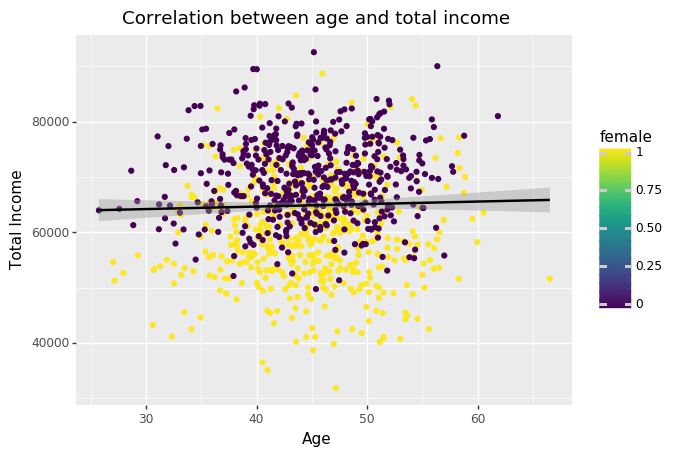

<ggplot: (22147817)>

In [15]:
#Import data
surv =  pd.read_csv('SurvIncome.txt', names=['tot_inc','wgt','age','female'])
surv.head()

#Draw a scatterplot of income and age, group by gender.
(ggplot(surv, aes('age', 'tot_inc'))
 + geom_point(aes(color='female'))
 + geom_smooth()
 + ggtitle("Correlation between age and total income")
 + ylab("Total Income")
 + xlab("Age")
)

From the plot, we can see that income increases almost linearly with age. It's consistent with the fact that income rises with experience. There is also significant difference in incomes between male and female at the same age. In fact, the average total income for male is 69864, while the average total income for female is 59878. Therefore, we could model the relationship between age and total income as:
$$age_i = \beta_0 + \beta_1 * income_i +\beta_2 * female,   i \in I = \{1, 2, 3, ..., N\}$$

Next, we want to observe the difference in weight between male and female participants.

female
0    169.563500
1    129.520862
Name: wgt, dtype: float64


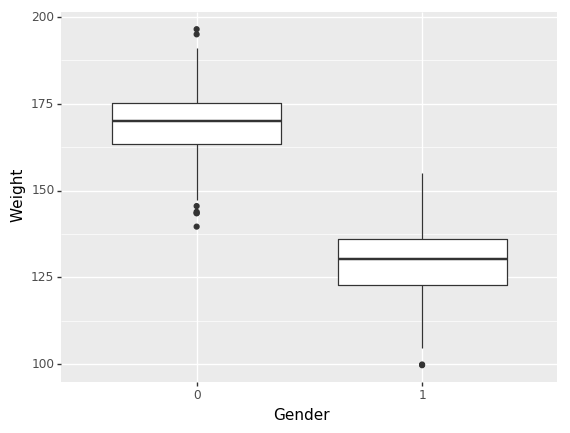

<ggplot: (22459059)>

In [16]:
surv.female = surv.female.astype(int).astype(str)
group = surv['wgt'].groupby(surv['female'])
print(group.mean())
(ggplot(surv, aes('female', 'wgt'))
 + geom_boxplot()
 + ylab("Weight")
 + xlab("Gender")
)

As expected, male and female participants vary greatly in weight. The average weight of male participants is 169.6 lbs, while the average weight of female participants is 129.5 lbs. From the boxplot, we could see that male and female weight have a very small overlapping area. The data pattern suggests that we could use a probit regression model to predict the female variable.
$$\Phi(female_i) = \beta_0 + \beta_1 * weight_i,   i \in I = \{1, 2, 3, ..., N\}$$

###### (b) Using your proposed method from part (a), impute the variables age ($age_i$) and gender ($female_i$) into the BestIncome.txt data.

First, we impute age with gender and total income observations.
$$age_i = \beta_0 + \beta_1 * income_i +\beta_2 * female,   i \in I = \{1, 2, 3, ..., N\}$$

In [17]:
#Define Outcome and Independent Variables
surv.female = surv.female.astype(int)
outcome  = 'age'
features = ['tot_inc', 'female']
X_vars, y = surv[features], surv[outcome]
X_vars = sm.add_constant(X_vars, prepend=False)

#Fit the model and get coefficients
res1 = sm.OLS(y, X_vars).fit()
print(res1.summary())

surv['age_hat'] = res1.predict(X_vars)
surv.head()

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5234
Date:                Mon, 15 Oct 2018   Prob (F-statistic):              0.593
Time:                        21:08:21   Log-Likelihood:                -3199.5
No. Observations:                1000   AIC:                             6405.
Df Residuals:                     997   BIC:                             6420.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
tot_inc     2.364e-05   2.31e-05      1.022      0.3

,tot_inc,wgt,age,female,age_hat
0,63642.513655,134.998269,46.610021,1,44.920988
1,49177.380692,134.392957,48.791349,1,44.579031
2,67833.339128,126.482992,48.429894,1,45.020060
3,62962.266217,128.038121,41.543926,1,44.904907
4,58716.952597,126.211980,41.201245,1,44.804548


As the dataset is very restricted, our model has a very low $R^2$, and the coefficients $\beta_1$ and $\beta_2$ are not significant.

Next, we can fit the probit model.

In [18]:
X_vars = surv['wgt']
X_vars = sm.add_constant(X_vars)
#Male and female are half to half
res2 = sm.Probit(surv['female'], X_vars).fit()
print(res2.summary())
surv['f_hat']=res2.predict(X_vars)

Optimization terminated successfully.
         Current function value: 0.043828
         Iterations 10
                          Probit Regression Results                           
Dep. Variable:                 female   No. Observations:                 1000
Model:                         Probit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Oct 2018   Pseudo R-squ.:                  0.9368
Time:                        21:08:21   Log-Likelihood:                -43.828
converged:                       True   LL-Null:                       -693.15
                                        LLR p-value:                2.234e-284
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.9663      3.797      9.210      0.000      27.525      42.408
wgt           -0.2338      0

In [19]:
best=pd.read_csv('BestIncome.txt', names=['lab_inc','cap_inc','hgt','wgt'])
#Total income equals labor income plus capital income
best['tot_inc'] = best.lab_inc + best.cap_inc
best_array = best.values

#Predict Z score using the probit model
Best_x1 = np.transpose(best_array[:, 3])
Best_x1 = sm.add_constant(Best_x1)
best_female = res2.predict(Best_x1)
best['female']=np.where(res2.predict(Best_x1)<0.5, 0, 1)
best_array = best.values

Best_x2 = np.transpose([best_array[:,4], best_array[:,5]])
Best_x2 = sm.add_constant(Best_x2, prepend=False)

#Impute age variable using the OLS model
best['age'] = res1.predict(Best_x2)
best.head()

,lab_inc,cap_inc,hgt,wgt,tot_inc,female,age
0,52655.605507,9279.509829,64.568138,152.920634,61935.115336,0,44.659196
1,70586.979225,9451.016902,65.727648,159.534414,80037.996127,0,45.087150
2,53738.008339,8078.132315,66.268796,152.502405,61816.140654,0,44.656384
3,55128.180903,12692.670403,62.910559,149.218189,67820.851305,1,45.019765
4,44482.794867,9812.975746,68.678295,152.726358,54295.770612,0,44.478601


In [20]:
#Drop temporary variables
best = best.drop(['tot_inc'],axis=1)

#Write to the file
best.to_csv('BestIncome_Impute.txt', header=None, index=None, sep=',', mode='w')

###### (c) Report the mean, standard deviation, minimum, maximum and number of observations for your imputed age ($age_i$) and gender ($female_i$) variables.

In [21]:
best[['age','female']].describe()

,age,female
count,10000.000000,10000.000000
mean,44.887261,0.485100
std,0.224577,0.499803
min,43.990573,0.000000
25%,44.733977,0.000000
50%,44.884606,0.000000
75%,45.042065,1.000000
max,45.732759,1.000000


###### (d) Report the correlation matrix for the now six variables -- labor income ($lab\_inc_i$), capital income ($cap\_ inc_i$), height ($hgt_i$), weight ($wgt_i$), age ($age_i$), and gender ($female_i$) -- in the BestIncome.txt data.

In [22]:
#In Matrix Form
corr = best.corr()
corr.style.background_gradient()

,lab_inc,cap_inc,hgt,wgt,female,age
lab_inc,1,0.0053253,0.00278978,0.00450691,-0.00499479,0.844633
cap_inc,0.0053253,1,0.0215716,0.00629868,-0.00491453,0.213679
hgt,0.00278978,0.0215716,1,0.172103,-0.138645,-0.0613996
wgt,0.00450691,0.00629868,0.172103,1,-0.797567,-0.387894
female,-0.00499479,-0.00491453,-0.138645,-0.797567,1,0.487532
age,0.844633,0.213679,-0.0613996,-0.387894,0.487532,1


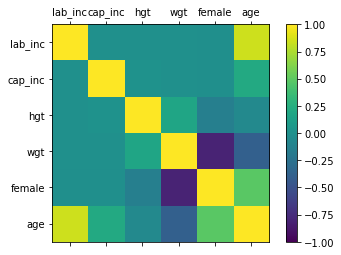

In [23]:
def corr_plot(df):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    names = df.columns
    N = len(names)
    
    correlations = df.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,N,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()
    
corr_plot(best)

### 2. Stationarity and data drift

###### (a) Estimate the coefficients in the regression above by ordinary least squares without making any changes to the data. Report your estimated coefficients and standard errors on those coefficients.

In [24]:
#Import the data
df = pd.read_csv('IncomeIntel.txt', names = ['grad_year', 'gre_qnt','salary_p4'])
df.grad_year = df.grad_year.astype(int)
df.describe()

,grad_year,gre_qnt,salary_p4
count,1000.000000,1000.000000,1000.000000
mean,2006.994000,596.510118,74173.293777
std,3.740582,242.361960,12173.767372
min,2001.000000,141.261398,43179.183141
25%,2004.000000,684.983551,65778.240317
50%,2007.000000,719.106878,73674.204810
75%,2010.000000,739.332537,81838.874129
max,2013.000000,799.715533,115367.665815


In [25]:
X_vars = df['gre_qnt']
X_vars = sm.add_constant(X_vars)
y = df['salary_p4']
model_salary = sm.OLS(y, X_vars).fit()
print(model_salary.summary())

                            OLS Regression Results                            
Dep. Variable:              salary_p4   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     356.3
Date:                Mon, 15 Oct 2018   Prob (F-statistic):           3.43e-68
Time:                        21:08:22   Log-Likelihood:                -10673.
No. Observations:                1000   AIC:                         2.135e+04
Df Residuals:                     998   BIC:                         2.136e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.954e+04    878.764    101.895      0.0

The constant is estimated to be 89540, standard error is 878; $\beta_1$ is estimated to be -25.76, standard error is 1.365.

###### (b) Create a scatter plot of GRE quantitative score (gre qnti) on the y-axis and graduation year (grad yeari) on the x-axis. Do any problems jump out in this variable and your ability to use it in testing your hypothesis? Propose and implement a solution for using this variable in your regression. 

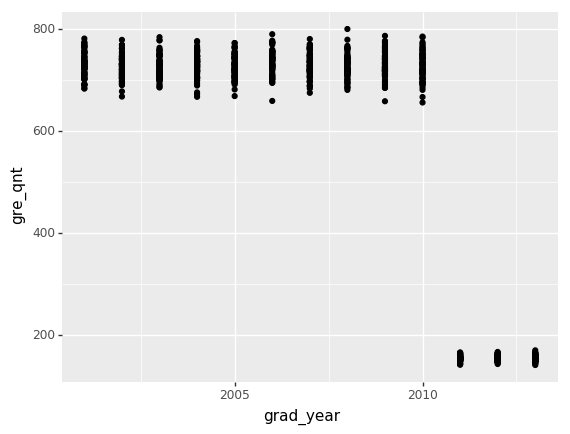

<ggplot: (1029805)>

In [26]:
(ggplot(df, aes('grad_year', 'gre_qnt'))
 + geom_point()
)

There is a kink in the GRE quant score at year 2011, because of the GRE reform that year. We can use official guidebook to convert new score to old score.
$$ old\_score = \beta_0 + \beta_1 * new\_score $$

In [27]:
#Convert new score to old score
#Source: https://www.ets.org/s/gre/pdf/concordance_information.pdf
benchmark ={800: 166,
790: 164,
780: 163,
770: 161,
760: 160,
750: 159,
740: 158,
730: 157,
720: 156,
710: 155,
700: 155,
690: 154,
680: 153,
670: 152,
660: 152,
650: 151,
640: 151}
score = pd.DataFrame(list(benchmark.items()), columns=['old','new'])

#Predict old score using new score
X_vars = score['new']
y = score['old']
X_vars = sm.add_constant(X_vars, prepend=False)

#Fit the model and get coefficients
m = sm.OLS(y, X_vars)
res = m.fit()

#Predict
df_xvar = np.transpose(df.values[:, 1])
df_xvar = sm.add_constant(df_xvar, prepend=False)
df['qnt_hat']=res.predict(df_xvar)

#If graduate year is after 2011, replace quant score with the prediction
df.gre_qnt = np.where(df.grad_year>=2011, df.qnt_hat, df.gre_qnt)
df.drop('qnt_hat', axis=1)

#Run the regression again
X_vars = df['gre_qnt']
X_vars = sm.add_constant(X_vars, prepend=False)
y = df['salary_p4']
model_salary = sm.OLS(y, X_vars).fit()
print(model_salary.summary())

                            OLS Regression Results                            
Dep. Variable:              salary_p4   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     38.46
Date:                Mon, 15 Oct 2018   Prob (F-statistic):           8.19e-10
Time:                        21:08:23   Log-Likelihood:                -10807.
No. Observations:                1000   AIC:                         2.162e+04
Df Residuals:                     998   BIC:                         2.163e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
gre_qnt      -65.7692     10.606     -6.201      0.0

###### (c) Create a scatter plot of income 4 years after graduation (salary p4i) on the y-axis and graduation year (grad yeari) on the x-axis. Do any problems jump out in this variable and your ability to use it in testing your hypothesis? Propose and implement a solution for using this variable in your regression.

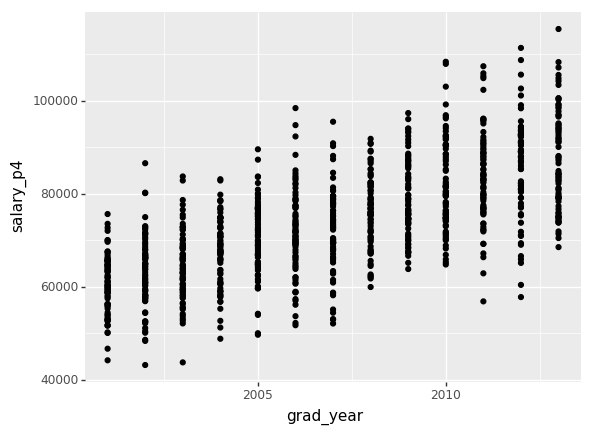

<ggplot: (1744579)>

In [28]:
(ggplot(df, aes('grad_year','salary_p4'))
 + geom_point()
)

In [29]:
print(df.groupby('grad_year')['salary_p4'].mean())

grad_year
2001    60710.709145
2002    63034.403163
2003    64518.742574
2004    67773.493082
2005    70492.592106
2006    71678.244222
2007    72133.654215
2008    76432.580321
2009    79030.629132
2010    81741.297377
2011    83563.850070
2012    86012.586076
2013    87300.521093
Name: salary_p4, dtype: float64


In order to study the causal relationship between intelligence and salary, we need to keep salary stationary. However, in the dataset, salary has an inflation over the year. That's why there is a negative relationship between salary and gre quant score. One possible solution is to deflate the salary with regard with base year 2011.
$$salary\_p4\_deflate_{it} = \dfrac{salary\_p4_{it}}{(1+growth\_rate)^{year-2011}} $$

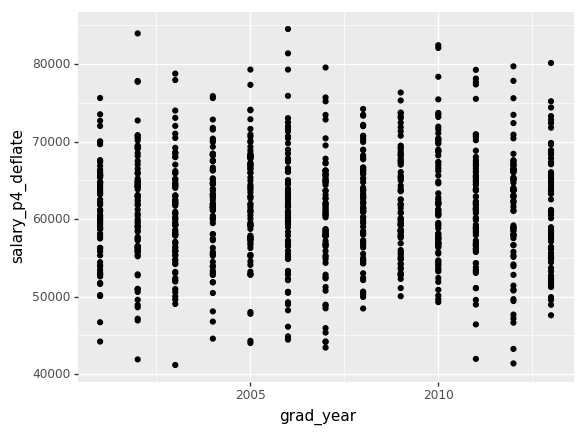

<ggplot: (1760725)>

In [30]:
avg_inc_by_year = df['salary_p4'].groupby(df['grad_year']).mean().values
avg_growth_rate = ((avg_inc_by_year[1:] - avg_inc_by_year[:-1]) / avg_inc_by_year[:-1]).mean()
deflate_growth = lambda x: x[2]/((1 + avg_growth_rate) ** (x[0] - 2001))
df['salary_p4_deflate'] = df.apply(deflate_growth, axis=1)
(ggplot(df, aes('grad_year','salary_p4_deflate'))
 + geom_point()
)

###### (d) Using the changes you proposed in parts (b) and (c), re-estimate the re-gression coefficients with your updated salary p4i and gre qnti variables.Report your new estimated coefficients and standard errors on those coeffficients. How do these coefficients differ from those in part (a)? Interpret why your changes from parts (b) and (c) resulted in those changes in coefficient values? What does this suggest about the answer to the question (evidence for or against your hypothesis)?

In [31]:
#Run the regression again
X_vars = df['gre_qnt']
X_vars = sm.add_constant(X_vars)
y = df['salary_p4_deflate']
model_salary = sm.OLS(y, X_vars).fit()
print(model_salary.summary())

                            OLS Regression Results                            
Dep. Variable:      salary_p4_deflate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4958
Date:                Mon, 15 Oct 2018   Prob (F-statistic):              0.482
Time:                        21:08:24   Log-Likelihood:                -10291.
No. Observations:                1000   AIC:                         2.059e+04
Df Residuals:                     998   BIC:                         2.060e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.464e+04   4576.142     14.125      0.0

Coefficient $\beta_1$ is about 2.5 times to the value in part(a). This is because we imputed the quant score after year 2011. $\beta_1$ is much larger compared to the value in part(b), because we have erased potential time trend in salaries. As p-value is very large, $\beta_1$ is not significant. Thus, the regression result cannot provide convincing evidence to reject the null hypothesis that intelligence is not related to higher income.

### 3. Assessment of Kossinets and Watts (2009)

Please see to attachment.